In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Data Medellin

In [2]:
TA = ['moravia_LH','floresta_HH','aguacatala_HL']
T = ['medellin', 'guadalajara']
zo = [T[0]] + TA
physical = ['grade_abs','den_pop','den_inter','ind_ndvi','land_use','sidewalk']
# zo = ['moravia_LH']
# z = zo[0]

edges = []
for z in zo:

    zone_edges = gpd.read_file(f'../data/output/shape/project_network_initial/{z}/{z}_edges_proj_net_initial.shp')
    zone_edges['territorio'] = z 

    # Import physical variables
    slope = gpd.read_file(f'../data/output/shape/physical_variables/slope/{z}/{z}_slope_edges.shp')
    popul = gpd.read_file(f'../data/output/shape/physical_variables/population/{z}/{z}_population_edges.shp')
    inter = gpd.read_file(f'../data/output/shape/physical_variables/intersections/{z}/{z}_intersections_edges.shp')
    veget = gpd.read_file(f'../data/output/shape/physical_variables/vegetation/{z}/{z}_vegetation_edges.shp')
    landu = gpd.read_file(f'../data/output/shape/physical_variables/land_use/{z}/{z}_land_use_edges.shp')
    sidew = gpd.read_file(f'../data/output/shape/physical_variables/sidewalks/{z}/{z}_sidewalks_edges.shp')

    # Filter the geodataframes
    slope = slope[['osmid','grade_abs']]
    popul = popul[['osmid','den_pop']]
    inter = inter[['osmid','den_inter']]
    veget = veget[['osmid','ind_ndvi']]
    landu = landu[['osmid','land_use']]
    sidew = sidew[['osmid','sidewalk']]

    # Combine all the networks
    zone_edges = zone_edges.merge(slope, how='left', on='osmid')
    zone_edges = zone_edges.merge(popul, how='left', on='osmid')
    zone_edges = zone_edges.merge(inter, how='left', on='osmid')
    zone_edges = zone_edges.merge(veget, how='left', on='osmid')
    zone_edges = zone_edges.merge(landu, how='left', on='osmid')
    zone_edges = zone_edges.merge(sidew, how='left', on='osmid')
    zone_edges = zone_edges.fillna(0)

    edges.append(zone_edges)

    # # Plot scatter matrix by territory
    # g = pd.plotting.scatter_matrix(zone_edges[physical], figsize=(10,10), marker = 'o', alpha = 0.8, hist_kwds = {'bins': 50}, s = 1)
    # plt.suptitle(z)
    # plt.show()

edges = pd.concat(edges, ignore_index = True)
edges = edges.fillna(0)

#Create a new column for "grade_abs" where the values ​​are "inverted" (1-grade_abs)
edges['grade_abs_'] = edges['grade_abs']
edges['grade_abs'] = 1 - edges['grade_abs_']

info = pd.DataFrame()

n = 0
for z in zo:
    for p in physical:
        info.loc[n,'territorio'] = z
        info.loc[n,'var'] = p
        info.loc[n,'min'] = edges[edges['territorio'] == z][p].min()
        info.loc[n,'max'] = edges[edges['territorio'] == z][p].max()
        info.loc[n,'mean'] = edges[edges['territorio'] == z][p].mean()
        info.loc[n,'med'] = edges[edges['territorio'] == z][p].median()
        info.loc[n,'std'] = edges[edges['territorio'] == z][p].std()
        n += 1

# Data Guadalajara

In [3]:
# Import physical variables from Guadalajara
edges_gua = gpd.read_file(f'../data/output/shape/project_network_final/{T[1]}/edges_var_gdl.gpkg')
edges_gua = edges_gua[['u', 'v', 'key', 'grade_abs', 'average_density', 'average_intersdens', 'ndvi_mean', 'entropy', 'banqueta_pct','geometry']]
edges_gua = edges_gua.rename(columns = {'average_density':'den_pop', 'average_intersdens':'den_inter', 'ndvi_mean':'ind_ndvi', 'entropy':'land_use', 'banqueta_pct':'sidewalk'})
edges_gua = edges_gua.fillna(0)

#Create a new column for "grade_abs" where the values ​​are "inverted" (1-grade_abs)
edges_gua['grade_abs_'] = edges_gua['grade_abs']
edges_gua['grade_abs'] = 1 - edges_gua['grade_abs_']

# DEA Medellin + Guadalajara

### Box plot Medellin + Guadalajara

In [4]:
# Construction of the box plot considering both the data from Medellin and Guadalajara
box_plot_all = pd.DataFrame()
for z in physical:
    edges_all = pd.concat([edges[edges['territorio'] == T[0]][z], edges_gua[z]], ignore_index = True)
    box_plot_all.loc[z, 'q1'] = edges_all.quantile(q = 0.25)
    box_plot_all.loc[z, 'q2'] = edges_all.quantile(q = 0.50)
    box_plot_all.loc[z, 'q3'] = edges_all.quantile(q = 0.75)
    box_plot_all.loc[z, 'iq'] = box_plot_all.loc[z, 'q3'] - box_plot_all.loc[z, 'q1']
    box_plot_all.loc[z, 'ls'] = box_plot_all.loc[z, 'q3'] + 1.5*box_plot_all.loc[z, 'iq']
    box_plot_all.loc[z, 'li'] = box_plot_all.loc[z, 'q1'] - 1.5*box_plot_all.loc[z, 'iq']
    if box_plot_all.loc[z, 'li'] < 0:
        box_plot_all.loc[z, 'li'] = 0

box_plot_all = box_plot_all.reset_index()
box_plot_all.to_csv('../data/output/table/normalization/box_plot_all.txt', index=False)
box_plot_all = box_plot_all.set_index('index')

### Normalization Medellin + Guadalajara

In [5]:
# Normalize the physical variables from Medellin
physicalN = [i+'N' for i in physical]
edges_norm_all_MED = edges.copy()
for col in physical:
    edges_norm_all_MED[f'{col}N'] = (edges[col]-box_plot_all.loc[col, 'li'])/(box_plot_all.loc[col, 'ls']-box_plot_all.loc[col, 'li'])
    edges_norm_all_MED[f'{col}N'] = edges_norm_all_MED[f'{col}N'].where(cond = edges_norm_all_MED[f'{col}N'] <= 1, other = 1)
    edges_norm_all_MED[f'{col}N'] = edges_norm_all_MED[f'{col}N'].where(cond = edges_norm_all_MED[f'{col}N'] >= 0, other = 0)
edges_norm_all_MED = edges_norm_all_MED.fillna(0)

# Normalize the physical variables from Guadalajara
edges_norm_all_GUA = edges_gua.copy()
for col in physical:
    edges_norm_all_GUA[f'{col}N'] = (edges_gua[col]-box_plot_all.loc[col, 'li'])/(box_plot_all.loc[col, 'ls']-box_plot_all.loc[col, 'li'])
    edges_norm_all_GUA[f'{col}N'] = edges_norm_all_GUA[f'{col}N'].where(cond = edges_norm_all_GUA[f'{col}N'] <= 1, other = 1)
    edges_norm_all_GUA[f'{col}N'] = edges_norm_all_GUA[f'{col}N'].where(cond = edges_norm_all_GUA[f'{col}N'] >= 0, other = 0)
edges_norm_all_GUA = edges_norm_all_GUA.fillna(0)


### Walkability_Index Medellin + Guadalajara

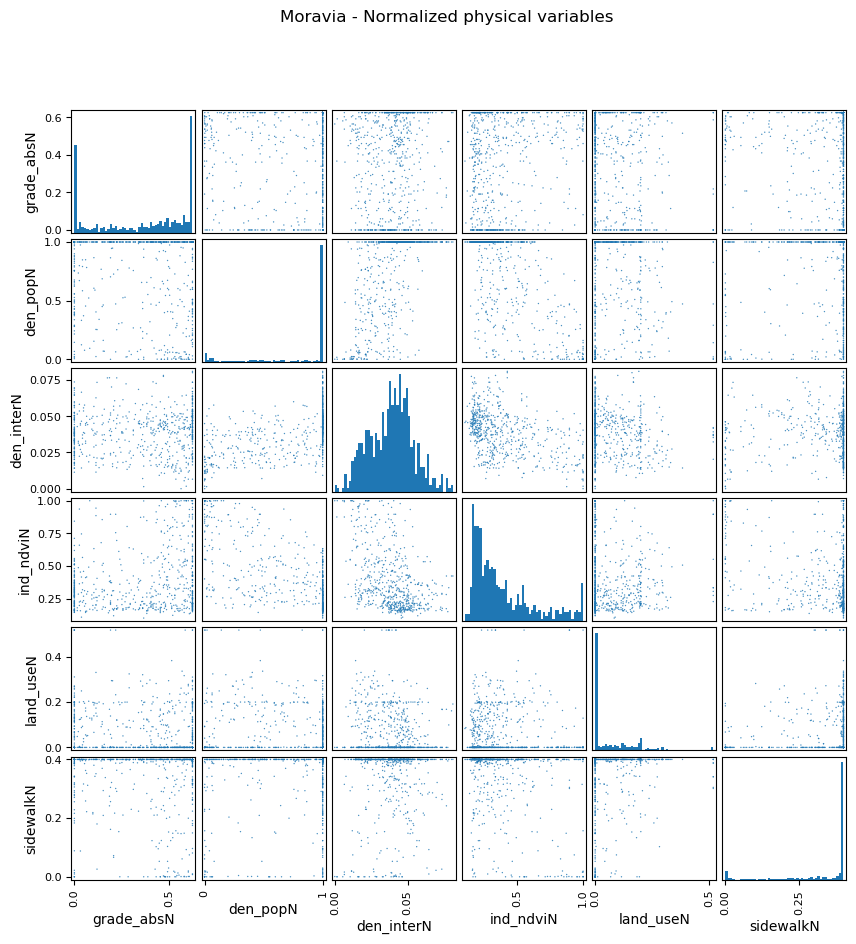

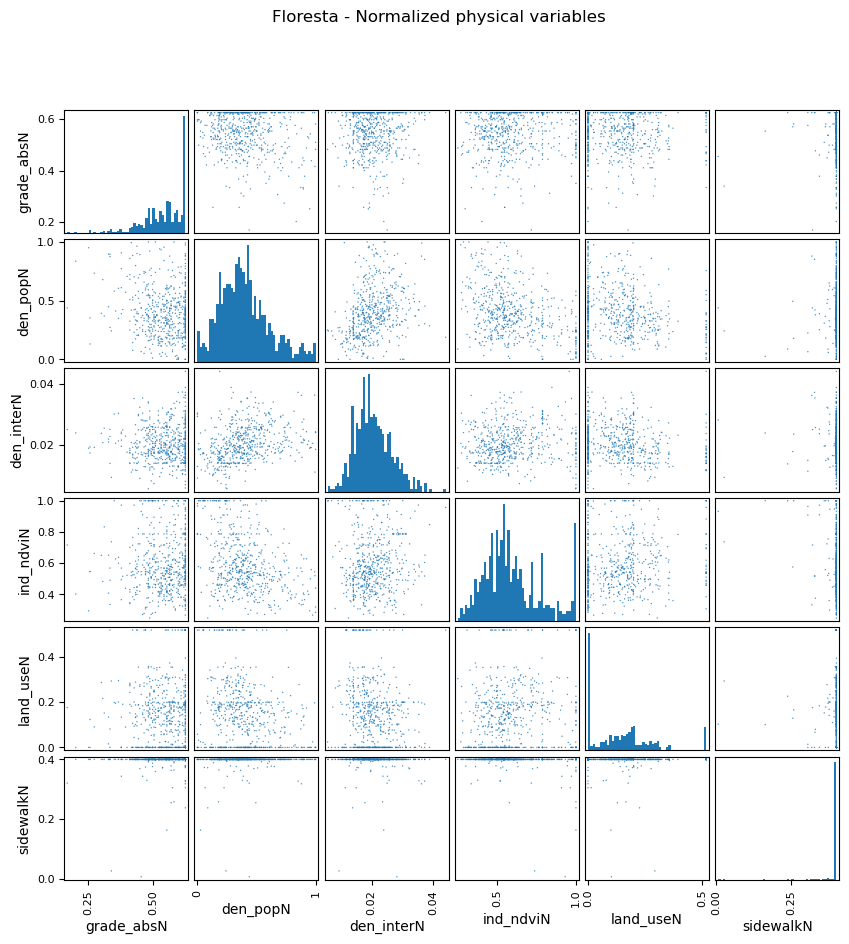

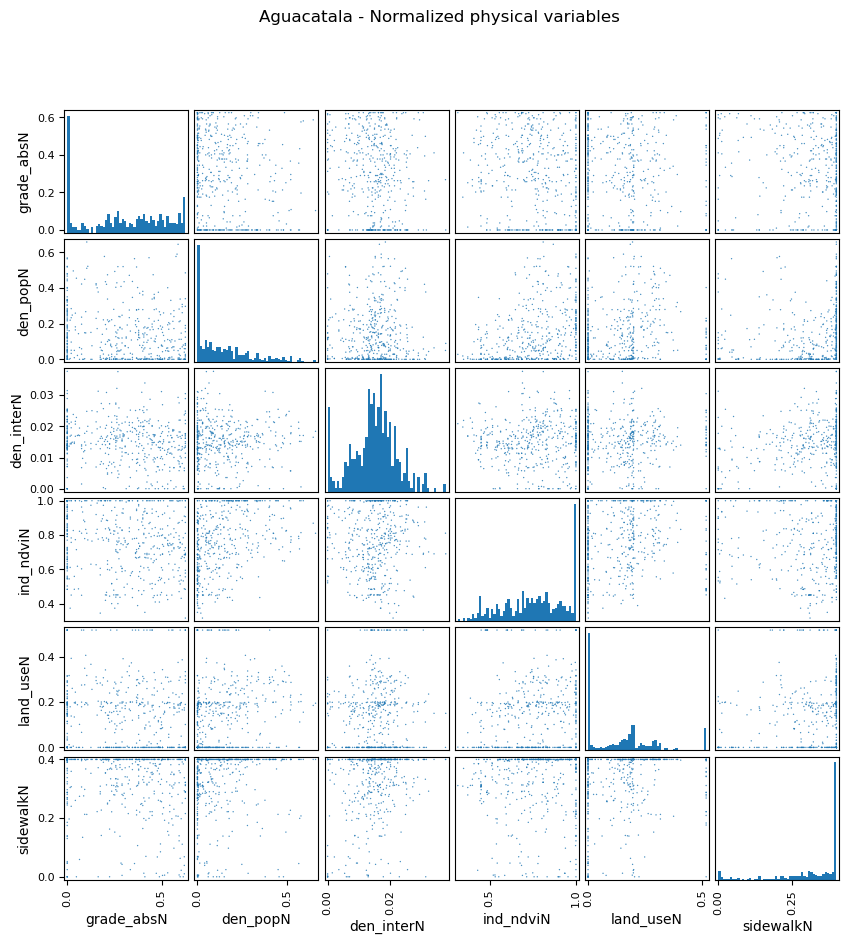

In [6]:
# Walkability index for the territories of Medellin
# z = TA[0]
for z in TA:
    zone_nodes = gpd.read_file(f'../data/output/shape/project_network_initial/{z}/{z}_nodes_proj_net_initial.shp')
    zone_edges = edges_norm_all_MED[edges_norm_all_MED['territorio'] == z].reset_index(drop = True)

    # Import perception variables
    # perception = pd.read_csv('../data/output/table/betas/try_betas.txt')
    name = z.split('_')[0].capitalize()
    perception = pd.read_csv(f'../data/output/table/betas/TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    perception['variable'] = perception['variable']+'N'
    perception = perception.set_index('variable')
    # Organice to have the same order as the physical variables
    perception = perception.T[physicalN].T

    # Aquired the Walkability Index
    zone_edges['WI'] = zone_edges[physicalN]@perception

    # Export
    zone_edges.to_file(f'../data/output/shape/project_network_final/{z}/{z}_edges_proj_net_final.shp')
    zone_nodes.to_file(f'../data/output/shape/project_network_final/{z}/{z}_nodes_proj_net_final.shp')

    # Limit the study area to the neighborhood polygon
    edges = zone_edges.copy()
    nodes = zone_nodes.copy()

    edges = edges.reset_index()
    edges = edges.to_crs('epsg:32618')
    nodes = nodes.reset_index()
    nodes = nodes.to_crs('epsg:32618')

    if z == 'floresta_HH':
        w = 'Alto_Alta'
    elif z == 'moravia_LH':
        w = 'Bajo_Alta'
    elif z == 'aguacatala_HL':
        w = 'Alto_Baja'

    # Load polygon files
    polygon = gpd.read_file(f'../data/input/shape/Poligonos/{w}.shp')
    polygon = polygon.to_crs('epsg:32618')
    polygon = polygon['geometry'].union_all()
    polygon = gpd.GeoDataFrame(geometry = [polygon], crs = 'epsg:32618')

    # Select the segments that are inside the polygon
    for idx, row in polygon.iterrows():
        # Filter the edges contained in the polygon
        edges_in_polygon = edges[edges['geometry'].intersects(row['geometry'])]

    # List of the nodes inside the polygon based on the 'u' and 'v' columns of the edges inside the polygon
    nodes_in_polygon = edges_in_polygon['u'].to_list() + edges_in_polygon['v'].to_list()
    # Make the nodes unique and sort it
    nodes_in_polygon = list(set(nodes_in_polygon))
    nodes_in_polygon.sort()
    # Select the nodes inside the buffer
    nodes_in_polygon = nodes.set_index('osmid').loc[nodes_in_polygon].reset_index()

    # Plot scatter matrix
    g = pd.plotting.scatter_matrix(edges_in_polygon[physicalN], figsize=(10,10), marker = 'o', alpha = 0.8, hist_kwds = {'bins': 50}, s = 1, )
    new_labels = [round(float(i.get_text()), 2) for i in g[0,0].get_yticklabels()]
    g[0,0].set_yticklabels(new_labels)
    plt.suptitle(z.split('_')[0].capitalize() + ' - Normalized physical variables')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(f'../data/output/image/physical_variables/scatter_matrix/{z}_scatter_matrix.png')
    # plt.show()

    # Export
    nodes_in_polygon = nodes_in_polygon.to_crs('epsg:4326')
    edges_in_polygon = edges_in_polygon.to_crs('epsg:4326')
    nodes_in_polygon.to_file(f'../data/output/shape/project_network_filter/{z}/{z}_nodes_proj_net_final.shp')
    edges_in_polygon.to_file(f'../data/output/shape/project_network_filter/{z}/{z}_edges_proj_net_final.shp')

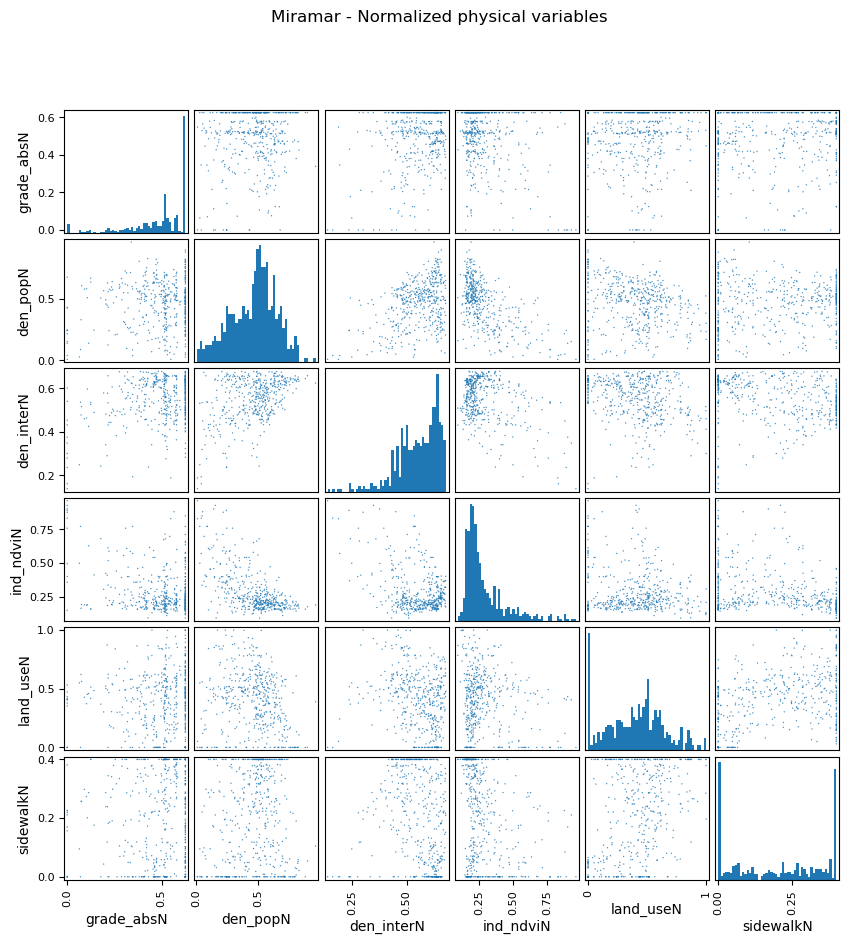

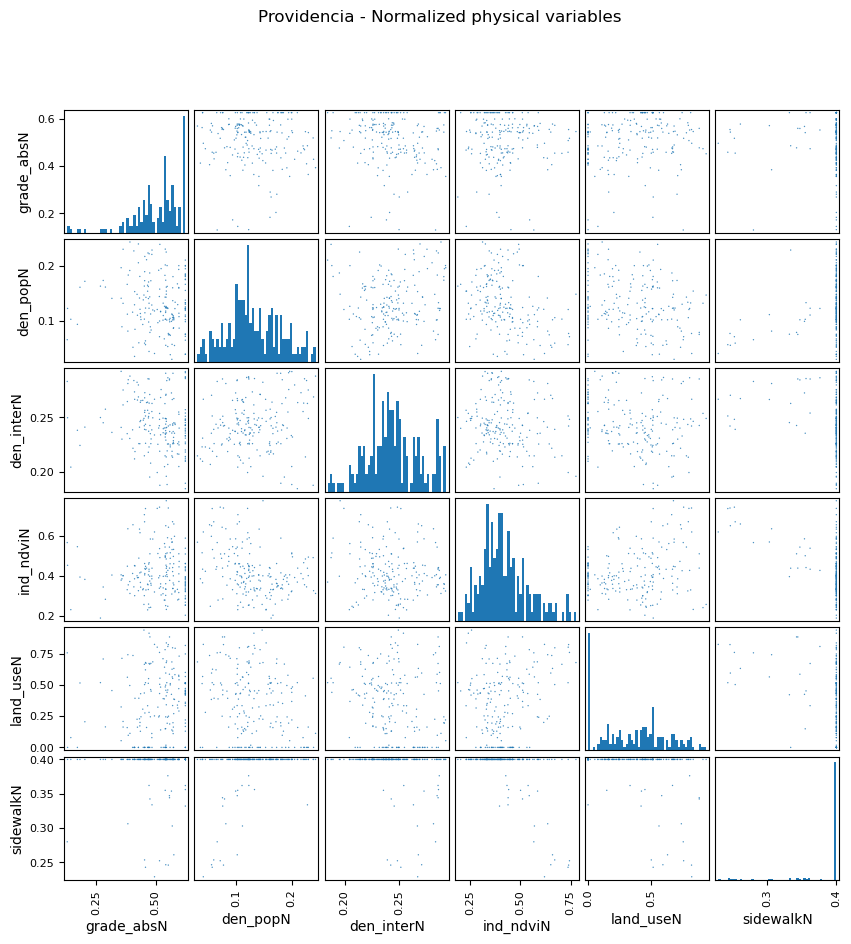

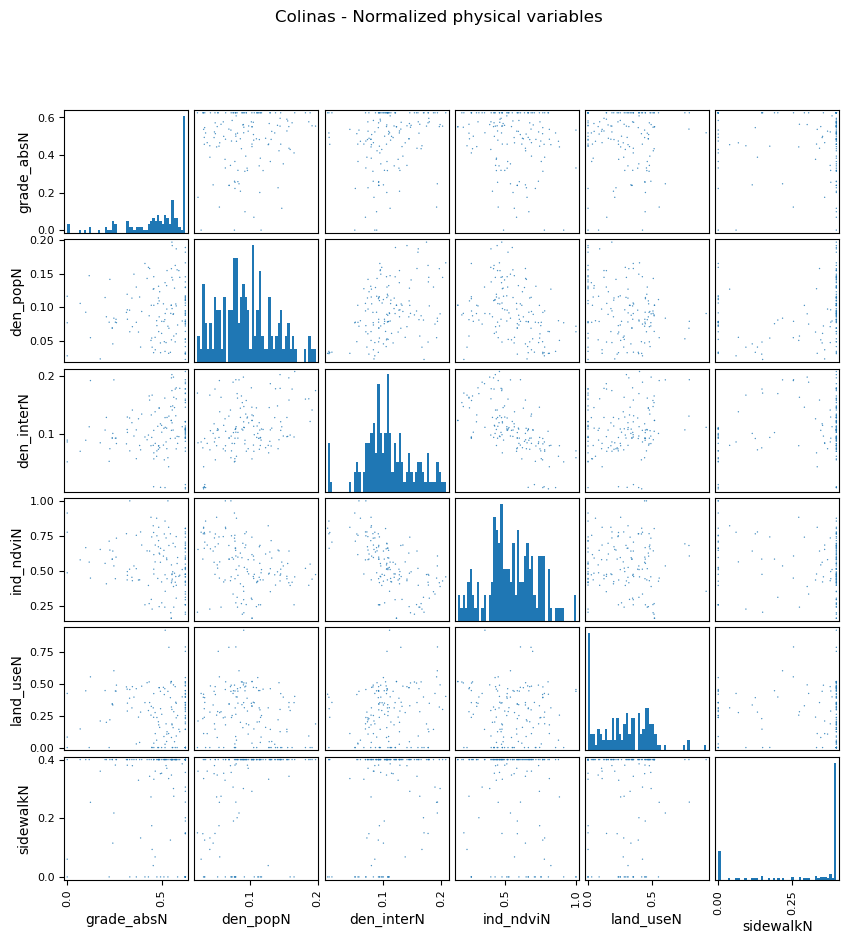

In [7]:
# Walkability index for the territories of Guadalajara
TA_GUA = ['miramar_LH', 'providencia_HH', 'colinas_HL']
# x = TA_GUA[0]
for x in TA_GUA:
    x_initial = x.split('_')[0]

    # Read nodes and edges of each of the Guadalajara territories
    territory_nodes = gpd.read_file(f'../data/output/shape/project_network_initial/guadalajara_partitions/{x_initial}_nodes_proj_net_rebuilt.gpkg') 
    territory_edges = gpd.read_file(f'../data/output/shape/project_network_initial/guadalajara_partitions/{x_initial}_edges_proj_net_rebuilt.gpkg')

    territory_nodes = territory_nodes.to_crs('epsg:32618')
    territory_edges = territory_edges.to_crs('epsg:32618')

    # Add a common column between the edges of each of the territories of Guadalajara and the GeoDataFrame that contains the physical variables of all of Guadalajara.
    territory_edges['edge_id'] = territory_edges['u'] + territory_edges['v'] + territory_edges['key']
    edges_norm_all_GUA['edge_id'] = edges_norm_all_GUA['u'].astype(str) + edges_norm_all_GUA['v'].astype(str) + edges_norm_all_GUA['key'].astype(str)

    # Merge territory_edges with edges_norm_all_GUA
    territory_edges = territory_edges.merge(edges_norm_all_GUA, on='edge_id')
    territory_edges = territory_edges[['u_x', 'v_x', 'key_x', 'geometry_x', 'edge_id', 'grade_abs', 'den_pop', 'den_inter', 'ind_ndvi', 'land_use', 'sidewalk', 'grade_abs_', 'grade_absN', 'den_popN', 'den_interN', 'ind_ndviN', 'land_useN', 'sidewalkN']]
    territory_edges = territory_edges.rename(columns = {'u_x':'u', 'v_x':'v', 'key_x':'key', 'geometry_x':'geometry'})

    # Export the physical variables of Guadalajara one by one for each territory
    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_slope_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'grade_abs_']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_slope_edges.shp')

    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_population_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'den_pop']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_population_edges.shp')

    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_intersections_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'den_inter']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_intersections_edges.shp')

    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_vegetation_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'ind_ndvi']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_vegetation_edges.shp')

    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_land_use_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'land_use']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_land_use_edges.shp')

    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_sidewalks_nodes.shp')
    territory_edges[['u', 'v', 'key', 'geometry', 'edge_id', 'sidewalk']].to_file(
        f'../data/output/shape/project_network_filter/{x}/{x}_sidewalks_edges.shp')

    # Calculate the Walkability Index
    # Import perception variables
    # perception = pd.read_csv('../data/output/table/betas/try_betas.txt')
    name = x.split('_')[0].capitalize()
    perception = pd.read_csv(f'../data/output/table/betas/TA_{name}_betas.txt')
    # Add the suffix 'N' to correctly multiply
    perception['variable'] = perception['variable']+'N'
    perception = perception.set_index('variable')
    # Organice to have the same order as the physical variables
    perception = perception.T[physicalN].T

    # Aquired the Walkability Index
    territory_edges['WI'] = territory_edges[physicalN]@perception

    # Plot scatter matrix
    g = pd.plotting.scatter_matrix(territory_edges[physicalN], figsize=(10,10), marker = 'o', alpha = 0.8, hist_kwds = {'bins': 50}, s = 1, )
    new_labels = [round(float(i.get_text()), 2) for i in g[0,0].get_yticklabels()]
    g[0,0].set_yticklabels(new_labels)
    plt.suptitle(x.split('_')[0].capitalize() + ' - Normalized physical variables')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(f'../data/output/image/physical_variables/scatter_matrix/{x}_scatter_matrix.png')
    # plt.show()

    # # Export
    territory_nodes = territory_nodes.to_crs('epsg:4326')
    territory_edges = territory_edges.to_crs('epsg:4326')
    territory_nodes.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_nodes_proj_net_final.shp')
    territory_edges.to_file(f'../data/output/shape/project_network_filter/{x}/{x}_edges_proj_net_final.shp')
